In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("font", family = "MicroSoft YaHei", weight = "bold") # 防止中文乱码

#### 简单起见只考虑解
$$
\frac{1}{2}||y-x\beta||^2+\mu||\beta||_{1,2}
$$
#### 的问题，其中$\beta$是一维向量，解法是采用近似点梯度（可能先实现次梯度下降，效率不重要）

#### 首先考虑p小于n的情形，方便做聚类

In [33]:
import random
p = 5 #beta的维度
n = 10 #样本个数

#初始化真实的beta
beta = np.random.randn(p)
div = [[0,2],[2,5]] #分组方式

beta[div[1][0]:div[1][1]] = 0
x = np.zeros([n,p])
a = np.random.randn(2,2)
x[:,:2] = np.random.multivariate_normal(np.zeros(2),0.1*np.dot(a.T,a),n)
x[:,2:5] = 2+2*np.random.randn(n,3)
y = np.dot(x,beta)
y += 1*np.random.rand(n)
mu = 1e-2

In [34]:
np.dot(np.dot(x,np.linalg.inv(np.dot(x.T,x))),x.T)

array([[ 0.14772246,  0.11873915,  0.05211766, -0.06760552,  0.09990519,
        -0.08419985,  0.18572629,  0.06359298,  0.21540101, -0.05008203],
       [ 0.11873915,  0.67863735, -0.20063792,  0.20603949, -0.05183819,
         0.07874255,  0.30203451, -0.07857922, -0.00193826, -0.12243769],
       [ 0.05211766, -0.20063792,  0.25936164, -0.0660725 ,  0.18516324,
        -0.05423652,  0.12646908,  0.29241492, -0.05683665,  0.05289075],
       [-0.06760552,  0.20603949, -0.0660725 ,  0.5242454 , -0.2318827 ,
         0.02587351, -0.02188078,  0.19859802, -0.04864963,  0.31827355],
       [ 0.09990519, -0.05183819,  0.18516324, -0.2318827 ,  0.39473438,
         0.29924403,  0.18918108,  0.10075366,  0.03941969, -0.03397367],
       [-0.08419985,  0.07874255, -0.05423652,  0.02587351,  0.29924403,
         0.80388434, -0.05614207, -0.12086543, -0.05524691,  0.17433781],
       [ 0.18572629,  0.30203451,  0.12646908, -0.02188078,  0.18918108,
        -0.05614207,  0.39799956,  0.20726699

In [35]:
np.linalg.svd(x)[1]

array([10.02438314,  7.3459437 ,  5.11447577,  0.84337503,  0.13607739])

In [36]:
beta

array([-0.0554419 ,  1.77558868,  0.        ,  0.        ,  0.        ])

In [37]:
np.dot(np.dot(np.linalg.inv(np.dot(x.T,x)),x.T),y)

array([ 1.27634847,  1.38050471, -0.06946289,  0.19573674,  0.14355153])

In [233]:
from sklearn.cluster import KMeans
mean_var = np.zeros([p,2])
for i in range(p):
    mean_var[i,0] = np.mean(x[:,i])
    mean_var[i,1] = np.var(x[:,i])

res = KMeans(n_clusters=2,random_state=9).fit_predict(mean_var)
res

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [251]:
res_raw = KMeans(n_clusters=20,random_state=9).fit_predict(x.T)
res_raw

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2, 14, 19,  2,  2,  2,  2,  9,  2, 12,  2,  2,  2, 17,
        2,  2,  8,  2,  0, 18, 16,  2,  2,  2,  2,  7,  2,  2,  2, 10,  2,
        2, 13,  2,  0,  6,  3,  4,  5, 11, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])

In [202]:
for i in range(p):
    x[:,i] /= np.linalg.norm(x[:,i])
res_std = KMeans(n_clusters=2,random_state=9).fit_predict(x.T)
res_std

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

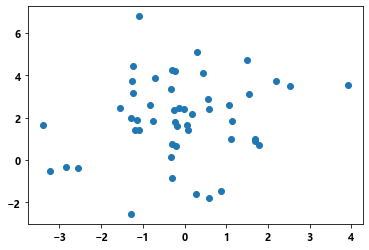

In [254]:
plt.scatter(x[:50,19],x[:50,20])
plt.show()

In [244]:
(abs(np.corrcoef(x.T)[0])>np.sum(abs(np.corrcoef(x.T)[0][1:]))*0.01)[:20]

array([ True, False,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True])

In [240]:
(abs(np.corrcoef(x.T)[1])>np.sum(abs(np.corrcoef(x.T)[1][1:]))*0.01)[:20]

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True])

In [249]:
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation(affinity='euclidean',convergence_iter=10).fit(x.T)
label = af.fit_predict(x.T)
label

D:\Anaconda\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "
D:\Anaconda\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

#### 根据相关系数聚类

In [367]:
def cor_means(k,x):
    dic = {}
    cls = {}
    for i in range(k):
        dic[i] = x[:,2*i]
        cls[i] = []
    it = 0
    while it < 10:
        for i in range(k):
            cls[i] = []
        for j in range(x.shape[1]):
            corr = [pd.Series(x[:,j]).corr(pd.Series(dic[i])) for i in range(k)]
            for s in range(k):
                if corr[s] == max(corr):
                    cls[s].append(j)
        for i in range(k):
            new_i = x[:,cls[i][0]]
            for j in range(1,len(cls[i])):
                new_i += x[:,cls[i][j]]
            dic[i] = new_i/np.linalg.norm(new_i,ord=2)
        it += 1
    corr = [pd.Series(x[:,3]).corr(pd.Series(dic[i])) for i in range(k)]
    #print(corr)
    return cls

In [374]:
p = 20 #beta的维度
n = 100 #样本个数

#初始化真实的beta
beta = np.random.randn(p)
div = [[2*i,2*i+2] for i in range(p//2)] #分组方式
for i in range(p//2):
    if i%2 == 0:
        beta[div[i][0]:div[i][1]] = 0
x = np.zeros([n,p])
for i in range(p//2):
    x[:,2*i] = np.random.randn(n).T
    x[:,2*i+1] = x[:,2*i]*2+10*np.random.randn(n).T
y = np.dot(x,beta)
y += 0.01*np.random.randn(n)

mu = 1e-2

In [375]:
cor_means(10,x)

{0: [0, 1],
 1: [2],
 2: [3, 4, 5],
 3: [6],
 4: [8],
 5: [9, 10, 11],
 6: [12],
 7: [13, 14, 15],
 8: [16, 17],
 9: [7, 18, 19]}

In [378]:
np.corrcoef(x.T)[3]

array([-0.04779298, -0.04917512, -0.10922596,  1.        ,  0.38982665,
        0.98777267, -0.02303855, -0.13670397, -0.00216102,  0.14265774,
        0.19408121,  0.12351199, -0.03165765,  0.02639746, -0.05969884,
        0.04109867,  0.03359882,  0.03398649, -0.11710198, -0.13058526])

In [106]:
#定义求值的函数
def f(y,x,beta,mu,div):
    return 0.5*np.linalg.norm(y-np.dot(x,beta), ord=2)**2+mu*g(beta,div)

def g(beta,div):
    s = 0
    for dd in div:
        s += np.linalg.norm(beta[dd[0]:dd[1]],ord=2)
    return s

def subgradient(beta,div):
    sub = np.zeros(beta.shape)
    for dd in div:
        if np.linalg.norm(beta[dd[0]:dd[1]])>0:
            sub[dd[0]:dd[1]] = beta[dd[0]:dd[1]]/np.linalg.norm(beta[dd[0]:dd[1]])
    return sub

def sub_dec(x,y,mu,beta0,div):
    k = 0
    t = 1e-5
    beta = beta0.copy()
    val = [f(y,x,beta,mu,div)]
    bb = [beta]
    mu0 = mu*10000
    while mu0 > mu:
        k = 0
        s = 0
        while k < 2000:
            beta -= t*(np.dot(x.T,np.dot(x,beta)-y)+mu0*subgradient(beta,div))
            ff = f(y,x,beta,mu0,div)
            if abs(ff-val[-1]) < 0.1**(3+s):
                break
            val.append(ff)
            bb.append(beta)
            k += 1
        mu0 /= 10
        s += 1
    k = 0
    while k < 10000:
        beta -= t*(np.dot(x.T,np.dot(x,beta)-y)+mu*subgradient(beta,div))
        ff = f(y,x,beta,mu,div)
        if abs(ff-val[-1]) < 1e-10:
            break
        val.append(ff)
        bb.append(beta)
        k += 1
    return beta,val

def sparsity(beta):
    return np.sum(abs(beta)>1e-4*np.sum(abs(beta)))/len(beta)

In [107]:
import random
p = 20 #beta的维度
n = 100 #样本个数

#初始化真实的beta
beta = np.random.randn(p)
div = [[0,p//5],[p//5,p]] #分组方式

beta[div[1][0]:div[1][1]] = 0
x = np.zeros([n,p])
a = np.random.randn(p//5,p//5)
x[:,:p//5] = np.random.multivariate_normal(np.zeros(p//5),0.1*np.dot(a.T,a),n)
x[:,p//5:p] = 2+2*np.random.randn(n,p-p//5)
y = np.dot(x,beta)
y += 1*np.random.rand(n)
mu = 1e-2

In [108]:
beta0 = np.random.rand(p)
mu = 1e-2
beta_r,val = sub_dec(x,y,mu,beta0,div)
div_f = [[i,i+1] for i in range(p)]
beta_f,val_f = sub_dec(x,y,mu,beta0,div_f)

In [120]:
div_f = [[i,i+1] for i in range(p)]
beta_f,val_f = sub_dec(x,y,mu,beta0,div_f)

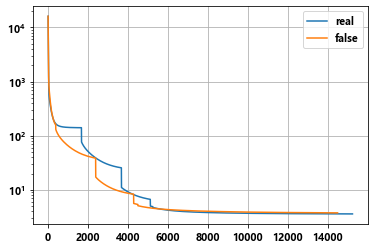

real:0.70 false:0.70


In [121]:
def sparsity(beta):
    return np.sum(abs(beta)>5e-3*np.sum(abs(beta)))/len(beta)
plt.semilogy(val)
plt.semilogy(val_f)
plt.legend(['real','false'])
plt.grid(True)
plt.show()
print('real:%.2f'%sparsity(beta_r),'false:%.2f'%sparsity(beta_f))

In [119]:
sparsity(np.dot(np.dot(np.linalg.inv(np.dot(x.T,x)+mu*np.eye(p)),x.T),y))

0.55

In [111]:
print(beta_r)
print(beta_f)
print(np.dot(np.dot(np.linalg.inv(np.dot(x.T,x)+mu*np.eye(p)),x.T),y))
print(beta)

[ 9.20570115e-01 -5.53421067e-01  1.54193275e+00 -3.33344144e-01
  1.54673366e-02  2.81242157e-02  2.59697022e-02  1.24407134e-02
  1.96230807e-02  2.48940252e-02 -2.31403026e-02  2.90550961e-02
  3.81524538e-03  4.73784055e-02  1.99141843e-02  1.90262980e-02
  4.16624117e-03  6.37731699e-04  2.83076147e-02 -1.64425558e-03]
[ 9.14497057e-01 -5.52343371e-01  1.54733325e+00 -3.24418213e-01
  1.55027514e-02  2.80130651e-02  2.60719486e-02  1.24757609e-02
  1.95694138e-02  2.49020709e-02 -2.31999156e-02  2.91356744e-02
  3.78918093e-03  4.75316728e-02  1.98392942e-02  1.89891521e-02
  4.20517127e-03  6.88661008e-04  2.82443413e-02 -1.67696396e-03]
[ 1.30604934e+00 -6.17717809e-01  1.20976064e+00 -8.77142146e-01
  1.39303341e-02  3.51287410e-02  1.97045113e-02  1.10903523e-02
  2.26156572e-02  2.38702331e-02 -2.02953517e-02  2.47350425e-02
  5.05734951e-03  3.85534455e-02  2.44173381e-02  2.14609436e-02
  2.01098502e-03 -2.52127329e-03  3.19136095e-02 -5.10149786e-05]
[ 1.23835137 -0.563081

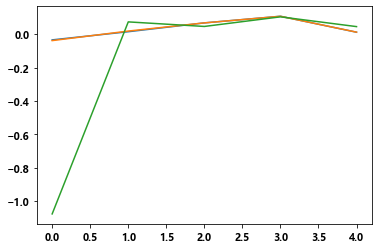

In [69]:
plt.plot(beta_r)
plt.plot(beta_f)
plt.plot(np.dot(np.dot(np.linalg.inv(np.dot(x.T,x)+mu*np.eye(5)),x.T),y))

In [50]:
div_f = [[i,i+1]for i in range(p)]
beta_f,val_f = sub_dec(x,y,mu,beta0,div_f)

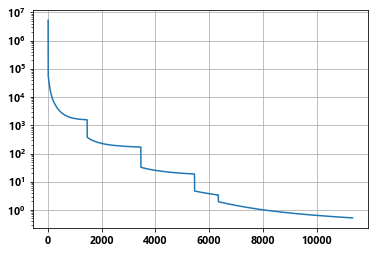

In [51]:
plt.semilogy(val_f)
plt.grid(True)
plt.show()

In [35]:
np.linalg.norm(beta_f-beta,2)

0.6724332510142969

In [124]:
f(y,x,beta_r,mu,div)-f(y,x,beta,mu,div)

-13.85196753623071

In [40]:
beta_r[:10]

array([ 0.07534522, -0.2732999 , -0.53766923,  0.66474365, -0.64161269,
       -0.35775392,  0.73140875,  0.24510669,  1.01174237, -0.21599963])

In [63]:
np.linalg.norm(beta_r-beta)-np.linalg.norm(beta_f-beta)

0.08294179421626541

In [221]:
f(y,x,np.array([1,0,0]),mu,div)-f(y,x,np.array([0.5,0.5,0]),mu,div)

-0.0012499999999999734

In [125]:
np.linalg.norm(y-np.dot(x,beta_f))

0.001119781342112775

In [127]:
np.dot(x,beta_f)[:10]

array([-14.87524265,   6.49451218,  -7.05489744, -17.25115369,
        -4.74789556,  -0.80808277, -10.07662031,   0.95622001,
        -2.60902611,  -4.34608205])

In [128]:
np.linalg.norm(beta)

10.90157451484927

In [141]:
np.sum(abs(beta_r))*1e-4

0.016979313783943458

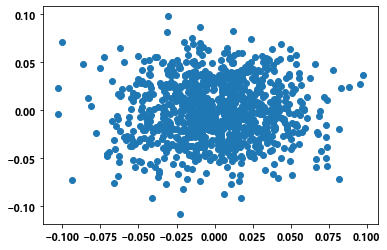

In [106]:
a = x[:,1]/np.linalg.norm(x[:,1])
b = x[:,0]/np.linalg.norm(x[:,0])
plt.scatter(a,b)
plt.show()

In [155]:
def find_div(k,x,beta):
    res_raw = KMeans(n_clusters=k,random_state=9).fit_predict(x.T)
    dic = {}
    for i in range(k):
        dic[i] = []
    for i in range(x.shape[1]):
        dic[res_raw[i]].append(i)
    beta_new = np.zeros(beta.shape)
    x_new = np.zeros(x.shape)
    j = 0
    kk = 0
    div = []
    while j < x.shape[1]:
        s = len(dic[kk])
        beta_new[j:j+s] = beta[dic[kk]].copy()
        x_new[j:j+s,:] = x[dic[kk],:].copy()
        div.append([j,j+s])
        j += s
        kk += 1
    return x_new,beta_new,div

#### 组内相关

In [345]:
p = 20 #beta的维度
n = 100 #样本个数

#初始化真实的beta
beta = np.random.randn(p)
div = [[2*i,2*i+2] for i in range(p//2)] #分组方式
for i in range(p//2):
    if i%2 == 0:
        beta[div[i][0]:div[i][1]] = 0
x = np.zeros([n,p])
for i in range(p//2):
    x[:,2*i] = np.random.randn(n).T
    x[:,2*i+1] = x[:,2*i]*2+0.01*np.random.randn(n).T
y = np.dot(x,beta)
y += 0.01*np.random.randn(n)

mu = 1e-2

In [177]:
beta0 = np.random.rand(p)
mu = 1e-2
div = [[i,i+1] for i in range(p)]
beta_r,val = sub_dec(x,y,mu,beta0,div)
beta_f,val_f = sub_dec(x_new,y_new,mu,beta0,div_new)

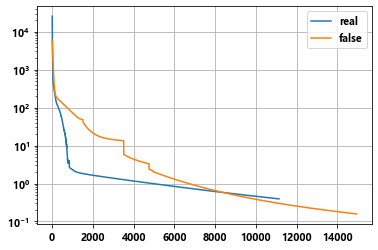

real:0.65 false:0.80


In [178]:
def sparsity(beta):
    return np.sum(abs(beta)>5e-3*np.sum(abs(beta)))/len(beta)
plt.semilogy(val)
plt.semilogy(val_f)
plt.legend(['real','false'])
plt.grid(True)
plt.show()
print('real:%.2f'%sparsity(beta_r),'false:%.2f'%sparsity(beta_f))

In [170]:
print(beta_f)
print(beta_new)

[ 0.05544992 -0.06822707  0.05332678 -0.00498716 -1.69754288  1.24274121
  0.10569761  1.3243058  -0.11010013  0.20401455  0.07311664 -0.08161433
  0.23771058  0.47071708  0.03940393 -0.24284173 -0.12473429  0.02379029
 -0.00896666 -0.10842012]
[ 0.          0.          0.          0.         -2.04527021  1.19683516
  0.31435989  1.44473867  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


In [171]:
print(beta_r)
print(beta)

[-1.65488422e+00  1.31505473e+00  8.59811578e-01  7.12471689e-01
  3.50090048e-03 -1.76465880e-03  1.12473049e-02 -9.49280618e-05
  2.72901585e-03  2.46856950e-03 -1.12375509e-02  7.22619918e-04
 -9.64068629e-03  1.55727921e-02 -4.42337679e-03 -8.80222279e-03
 -1.18558678e-03 -1.00409211e-02  1.57039546e-02 -2.22824985e-03]
[-2.04527021  1.19683516  0.31435989  1.44473867  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


In [242]:
p = 3 #beta的维度
n = 4 #样本个数

#初始化真实的beta
beta = np.array([1,0,0])
div = [[0,2],[2,3]] #分组方式

x = np.array([[1,1.1,0],[2,2.2,0],[3,3.3,0],[4,4.4,0]])
y = np.dot(x,beta)
mu = 1e-2

In [313]:
beta0 = np.random.rand(p)
mu = 1
#div = [[i,i+1] for i in range(p)]
beta_r,val = sub_dec(x,y,mu,beta0,div)
div1 = [[i,i+1] for i in range(p)]
beta_e,e_val = elastic(x,y,0.5*mu,0.5*mu,beta0,div1)

In [314]:
print(beta_r)
print(beta)
print(beta_e)

[ 4.89460444e-06  3.31889512e-05 -3.85294651e-02 -7.70584068e-02
 -3.57703602e-05 -7.15402909e-05 -7.70510136e-01 -1.55232299e+00
 -3.72049473e-06 -7.44095096e-06 -2.81618139e-01 -5.63710103e-01
  3.37916461e-05  6.80169019e-05 -1.05590954e-01 -2.11176069e-01
  2.29221604e-05  4.58433571e-05 -5.94356891e-01 -1.17346131e+00]
[ 0.          0.          0.0562448  -0.1264971   0.          0.
  0.57321114 -2.22640844  0.          0.          1.16673953 -1.28934257
  0.          0.          0.3592018  -0.44664565  0.          0.
 -0.31919212 -1.31393834]
[-8.16895837e-05 -9.73321128e-05  3.70452630e-05 -9.60369372e-02
 -1.03381874e-04  2.91074412e-05 -2.38832780e-05 -1.93724126e+00
 -3.18485219e-06 -9.13120630e-05 -6.16094632e-05 -7.04311488e-01
 -5.03813219e-05  8.37274286e-05 -8.51643167e-05 -2.63659279e-01
  7.42147589e-05 -7.56194972e-05 -5.88570755e-05 -1.47026403e+00]


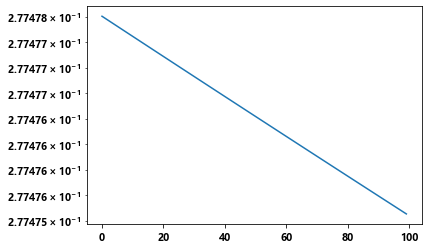

In [266]:
plt.semilogy(val[-100:])

In [237]:
#定义求值的函数
def f(y,x,beta,mu,div):
    return 0.5*np.linalg.norm(y-np.dot(x,beta), ord=2)**2+mu*g(beta,div)

def g(beta,div):
    s = 0
    for dd in div:
        s += np.linalg.norm(beta[dd[0]:dd[1]],ord=2)
    return s

def subgradient(beta,div):
    sub = np.zeros(beta.shape)
    for dd in div:
        if np.linalg.norm(beta[dd[0]:dd[1]])>0:
            sub[dd[0]:dd[1]] = beta[dd[0]:dd[1]]/np.linalg.norm(beta[dd[0]:dd[1]])
    return sub

def sub_dec(x,y,mu,beta0,div):
    k = 0
    t = 1e-4
    beta = beta0.copy()
    val = [f(y,x,beta,mu,div)]
    bb = [beta]

    while k < 50000:
        beta -= t*(np.dot(x.T,np.dot(x,beta)-y)+mu*subgradient(beta,div))
        ff = f(y,x,beta,mu,div)
        if abs(ff-val[-1]) < 1e-10:
            break
        val.append(ff)
        bb.append(beta)
        k += 1
        #t /= (k+1)/k
    return beta,val

def sparsity(beta):
    return np.sum(abs(beta)>1e-4*np.sum(abs(beta)))/len(beta)

In [312]:
#定义求值的函数
def e_f(y,x,beta,mu1,mu2,div):
    return 0.5*np.linalg.norm(y-np.dot(x,beta), ord=2)**2+e_g(beta,mu1,mu2,div)

def e_g(beta,mu1,mu2,div):
    s = 0
    for dd in div:
        s += mu1*np.linalg.norm(beta[dd[0]:dd[1]],ord=2)**2+mu2*np.linalg.norm(beta[dd[0]:dd[1]],ord=1)
    return s

def e_subgradient(beta,mu1,mu2,div):
    sub = np.zeros(beta.shape)
    for dd in div:
        if np.linalg.norm(beta[dd[0]:dd[1]])>0:
            sub[dd[0]:dd[1]] = mu1*beta[dd[0]:dd[1]]/np.linalg.norm(beta[dd[0]:dd[1]])
            for i in range(dd[0],dd[1]):
                if sub[i] > 0:
                    sub[i] += mu2
                else:
                    sub[i] -= mu2
    return sub

def elastic(x,y,mu1,mu2,beta0,div):
    k = 0
    t = 1e-4
    beta = beta0.copy()
    val = [e_f(y,x,beta,mu1,mu2,div)]
    bb = [beta]

    while k < 50000:
        beta -= t*(np.dot(x.T,np.dot(x,beta)-y)+e_subgradient(beta,mu1,mu2,div))
        ff = e_f(y,x,beta,mu1,mu2,div)
        if abs(ff-val[-1]) < 1e-10:
            break
        val.append(ff)
        bb.append(beta)
        k += 1
        #t /= (k+1)/k
    return beta,val

def sparsity(beta):
    return np.sum(abs(beta)>1e-4*np.sum(abs(beta)))/len(beta)

In [275]:
from sklearn import linear_model
lasso_model = linear_model.Lasso(alpha=0.1)
lasso_model.fit(x, y)
print(lasso_model.coef_)

[-0.          0.         -0.55678211 -0.53456385 -0.          0.
 -0.         -0.01046117 -0.          0.02656236  0.00841342 -0.01344567
 -0.          0.         -0.0069989   0.         -0.         -0.
 -0.         -0.        ]


In [269]:
beta

array([ 0.12735122, -0.42990848, -2.19433266, -1.19026633,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [270]:
from sklearn import linear_model
lasso_model = linear_model.ElasticNet(alpha=0.1,l1_ratio=0.8)
lasso_model.fit(x, y)
print(lasso_model.coef_)

[-0.          0.         -0.64625094 -0.57547422 -0.          0.
 -0.         -0.01500159 -0.          0.029021    0.0121991  -0.01528269
 -0.          0.         -0.00949375  0.         -0.         -0.
 -0.         -0.        ]


In [276]:
+np.linalg.norm(np.array([1,2,3]),ord=1)

6.0